In [1]:
AD_F = "cellSNP.tag.AD.mtx"
DP_F = "cellSNP.tag.DP.mtx"
VCF_F = "cellSNP.base.vcf"
INDIR='.'
#OUTDIR='./results/'
NUM_DONORS=2
prob_threshold=0.8

In [2]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join


In [3]:
# if not os.path.exists(OUTDIR):
#     os.mkdir(OUTDIR)

In [4]:
# data = ["data/vireo/pseudo/numC1000_ispropFalse", 
#  "data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP", '--num_cells', 1000, '--is_prop', False]

outdir = "data/vireo/pseudo/numC1000_ispropFalse"
indirs = ("data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP")
num_cells_total = 2000
is_proportional = False
cell_subsample=0.1

In [5]:
from os.path import join
import os
from numpy import random
import numpy as np
import pandas as pd
import click
import sys

def load_mtx_df(in_f, skip_first=True):
    df = pd.read_csv(in_f, comment="%", header=None, sep="\t")
    df.columns = ["Variant", "Cell", "integer"]
    if skip_first:
        df = df.iloc[1:] # Seems to be summary values
    return df



##  Merges the variant files called from cellSNP and creates the old to new map

In [6]:
""" Merges the variant files called from cellSNP

:param indirs:
:return:
"""
variants = pd.read_csv(join(indirs[0], "cellSNP.base.vcf"),
                       skiprows=1, sep="\t")
old_variants = {}
old_variants[indirs[0]] = variants.copy()
old_variants[indirs[0]].loc[:,"old"] = 0
old_variants[indirs[0]].loc[:,"old"] = old_variants[indirs[0]].index+1
#variants[indirs[0]] = variants.index.values + 1
for ind, val in enumerate(indirs[1:]):
    curr = pd.read_csv(join(val, "cellSNP.base.vcf"), skiprows=1,
                       sep="\t")
    #curr["old index"] = curr.index.values+1
    #curr[val] = curr.index.values + 1
    variants = pd.merge(variants, curr, on=["#CHROM", "POS", "ALT"],
                        how="outer")
    old_variants[val] = curr.copy()
    old_variants[val]["old"] = 0 
    old_variants[val]["old"] = curr.index.values+1

In [7]:

# Loop again and map the coordinates
vars_coords = dict()
variants["new ID"] = variants.index.values+1
full_vars = variants.copy()

# what the new index should be.
for val in indirs:
    curr_vars = pd.read_csv(join(val, "cellSNP.base.vcf"),
                            skiprows=1, sep="\t")
    curr_vars["old index"] = curr_vars.index+1
    curr_vars = pd.merge(curr_vars, full_vars, how="inner", on=["#CHROM", "POS", "ALT"])
    curr_vars.index = curr_vars["old index"]
    vars_coords[val] = curr_vars["new ID"]  # Pandas series

if outdir is not None:
    variants.to_csv(join(outdir, "cellSNP.base.vcf"), sep='\t', index=False)
    for ind, val in enumerate(indirs):
        out_f = join(outdir, f"variant_indices_{ind}.tsv")
        vars_coords[val].index.name = val
        vars_coords[val].to_csv(out_f, sep="\t") #Use index + header

#vars_coords, variants = merge_vcf_ids(indirs, outdir=outdir)

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


### Get the number of cells for the proportion

In [8]:
print(outdir, indirs, cell_subsample,
                          num_cells_total,
                          is_proportional)
print(type(is_proportional))
if outdir in indirs:
    raise ValueError("Outdir is one of the indirs. This cant be. Please change one.")
# Count number of cells first
cell_count = {}
for i in indirs:
    dp_f = join(i, "cellSNP.tag.DP.mtx")
    dp = pd.read_csv(dp_f, comment="%", header=None, sep="\t")
    dp.columns = ["Variant", "Cell", "integer"]
    dp = dp.iloc[1:]
    cell_count[i] = len(set(dp["Cell"].values))
cell_proportion = np.array(list(cell_count.values()))/sum(cell_count.values())
print('cell proportion', cell_proportion)

# ad["Variant"] = vars_coords[ad["Variant"]]
# dp["Variant"] = vars_coords[dp["Variant"]]
# oth["Variant"] = vars_coords[oth["Variant"]]

data/vireo/pseudo/numC1000_ispropFalse ('data/PBMC_J_cellSNP', 'data/PBMC_P_cellSNP') 0.1 2000 False
<class 'bool'>
cell proportion [0.53297953 0.46702047]


In [9]:
all_ads = {}
all_dps = {}
all_oths = {}
for i in indirs:
    ad_f = join(i, "cellSNP.tag.AD.mtx")
    dp_f = join(i, "cellSNP.tag.DP.mtx")
    oth_f = join(i, "cellSNP.tag.OTH.mtx")

    ad = load_mtx_df(ad_f, skip_first=False)
    dp = load_mtx_df(dp_f, skip_first=False)
    oth = load_mtx_df(oth_f, skip_first=False)
    all_ads[i] = ad
    all_dps[i] = dp
    all_oths[i] = oth

In [10]:
ad

,Variant,Cell,integer
0,1003,663,8090
1,2,546,1
2,4,14,1
3,4,22,2
4,4,24,1
...,...,...,...
8086,996,520,1
8087,996,532,2
8088,996,533,2
8089,996,654,1


In [11]:
dp

,Variant,Cell,integer
0,1003,663,15947
1,1,50,1
2,1,53,2
3,1,57,2
4,1,61,2
...,...,...,...
15943,1002,135,1
15944,1002,257,1
15945,1002,572,1
15946,1002,614,1


In [12]:
oth

,Variant,Cell,integer
0,1003,663,15020
1,1,289,1
2,1,388,1
3,3,13,2
4,3,14,4
...,...,...,...
15016,1003,535,2
15017,1003,549,1
15018,1003,592,2
15019,1003,597,1


In [13]:
print('oth', len(set(oth["Variant"].values)))
print('dp', len(set(dp["Variant"].values)))
print('ad', len(set(ad["Variant"].values)))

oth 874
dp 910
ad 526


In [28]:
oth

,Variant,Cell,integer
0,1003,663,15020
1,1,289,1
2,1,388,1
3,3,13,2
4,3,14,4
...,...,...,...
15016,1003,535,2
15017,1003,549,1
15018,1003,592,2
15019,1003,597,1


## For the cells, Dp should include ad, but oth, which is not the reference or not the vcf alternative allele, can be unique, but ideally low. This is what we see below. 
Additionally, we see that the integers are missing, implying that some were filtered out.

## For variants, we see it similarly. 
We see in this case though that no variants were filtered out. That doesn't always have to be the case I believe. 

### Variants

Total number of unique Variants
1003
Max int of Variant
ad 1003
dp 1003
oth 1003


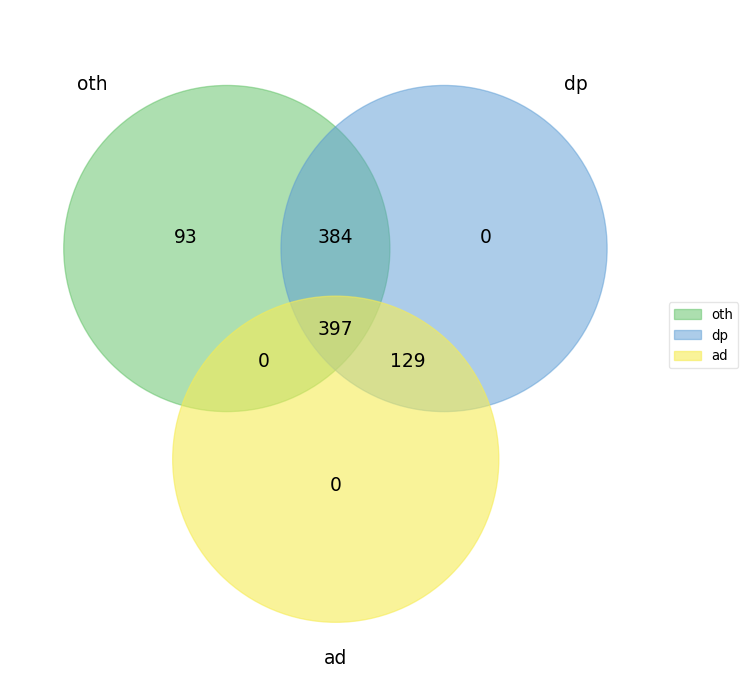

In [30]:
#from matplotlib.pyplot as plt
from src.external.pyvenn import venn

%matplotlib inline
labels = venn.get_labels([set(oth["Variant"].values),set(dp["Variant"].values), set(ad["Variant"].values) ])
fig, ax = venn.venn3(labels, names=['oth', 'dp','ad'])
print("Total number of unique Variants")
print(len(set(oth["Variant"].values).union(set(dp["Variant"].values).union(set(ad["Variant"].values)))))

print("Max int of Variant")
print("ad", ad["Variant"].max())
print("dp", dp["Variant"].max())
print("oth", oth["Variant"].max())

Total number of unique Cells
631
Max int of cell
ad 663
dp 663
oth 663


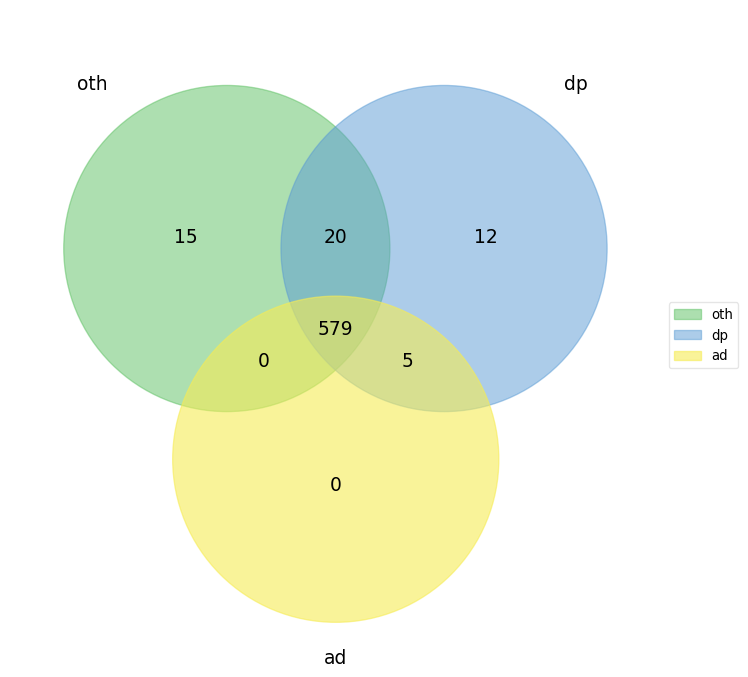

In [29]:
#from matplotlib.pyplot as plt
from src.external.pyvenn import venn

%matplotlib inline
labels = venn.get_labels([set(oth["Cell"].values),set(dp["Cell"].values), set(ad["Cell"].values) ])
fig, ax = venn.venn3(labels, names=['oth', 'dp','ad'])
print("Total number of unique Cells")
print(len(set(oth["Cell"].values).union(set(dp["Cell"].values).union(set(ad["Cell"].values)))))

print("Max int of cell")
print("ad", ad["Cell"].max())
print("dp", dp["Cell"].max())
print("oth", oth["Cell"].max())